# Monte Carlo simulation

Monte Carlo simulation is a simple technique with many, many powerful applications. Applications include radiotherapy, traffic flow analysis, econometrics, quantum chromodynamics, VLSI design, oil well exploration, and almost every field that involves numerical modelling. 

This notebook shows how you can do Monte Carlo integration in parallel across multiple cores or multiple nodes.

## Basics

We will start with the simple example of estimating $\pi$ as $4 \times$ the shaded area in a unit circle:

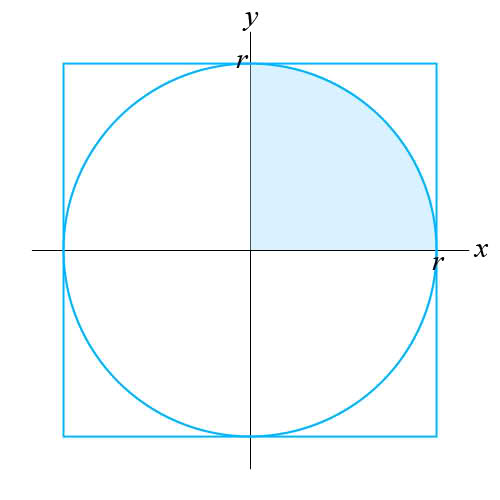

In [16]:
from IPython.core.display import Image
Image('http://i37.tinypic.com/2v7yrva.jpg')

We can do this with Monte Carlo integration by simulating random points $(x, y)$ between 0 and 1 and counting the proportion that land in a circle of radius 1:

In [17]:
Image('http://pythonio.com/media/uploads/pi_quarter.png')

In [18]:
import numpy as np

In [19]:
def estimate_pi_simple(n=10**6):
    """
    Samples n points (x, y); computes the distance of each 
    from the origin; estimates pi as 4 x the proportion
    of points that land in the unit circle.
    """
    x, y = np.random.rand(2, n)
    return 4 * np.mean(np.hypot(x, y) < 1)

In [20]:
estimate_pi_simple()

3.140768

In [21]:
%timeit estimate_pi_simple()

10 loops, best of 3: 32.1 ms per loop


## Accuracy to 5 decimal places: 3.14160

Suppose we want to estimate $\pi$ accurate to 5 decimal places. How many samples will this require?

Let's estimate the standard deviation of our estimator empirically with 100 runs:

In [22]:
estimates = [estimate_pi_simple() for i in range(100)]
err = np.std(estimates)
err

0.0016319135545732433

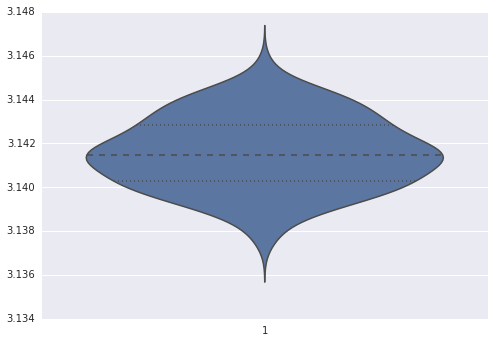

In [24]:
%matplotlib inline
import seaborn as sns
sns.violinplot(estimates);

We want 5 decimal places of accuracy, so we want to reduce the standard error by a factor of:

In [25]:
err / 0.00001

163.19135545732431

Since the standard deviation of our basic Monte Carlo estimator is $\sigma(\hat{\pi}) \propto 1 / \sqrt{n}$,
the factor we'd need to increase $n$ is the *square* of this:

In [26]:
nfactor = (err / 0.00001)**2
nfactor

26631.418495998772

How long would this simulation take?

In [27]:
%timeit estimate_pi_simple()

10 loops, best of 3: 32.1 ms per loop


In [28]:
seconds = nfactor * 31.3 / 1000
minutes = seconds / 60
minutes

13.892723315412693

# Efficiency

How can we speed this up? Here we will apply two approaches: Numexpr and IPython Parallel.

### Numexpr

In [29]:
import numexpr as ne

In [30]:
ne.ncores

8

In [31]:
def estimate_pi_numexpr(n=10**6):
    """
    Samples n points (x, y); computes the distance of each 
    from the origin; estimates pi as 4 x the proportion
    of points that land in the unit circle.
    """
    x, y = np.random.rand(2, n)
    return 4 * ne.evaluate('x**2 + y**2 < 1').mean()

In [32]:
estimate_pi_numexpr()

3.141356

In [33]:
%timeit estimate_pi_numexpr()

10 loops, best of 3: 28 ms per loop


The code hasn't sped up by much. Is there more efficiency to be gained from Numexpr with larger arrays?

In [34]:
%timeit estimate_pi_simple(10**7)

1 loops, best of 3: 387 ms per loop


In [35]:
%timeit estimate_pi_numexpr(10**7)

1 loops, best of 3: 322 ms per loop


Answer: yes, a little: about 20% in these tests.

### IPython Parallel

In [ ]:
from IPython.parallel import Client

TODO: start one or more engines now from the Clusters tab in the IPython Notebook menu browser tab.

In [ ]:
client = Client()
client.ids

In [ ]:
view = client[:]

In [ ]:
# with view.sync_imports():
#     import numpy    # doesn't currently work in Py3.4
view.execute('import numpy as np')
view.execute('import numexpr as ne')

In [ ]:
view.apply_sync(estimate_pi_numexpr)

In [ ]:
%timeit view.apply_sync(estimate_pi_numexpr, 10**7)

# Bootstrapping confidence intervals

The **bootstrap** is a computationally intensive procedure for making inferences from data when the underlying distribution is unknown or difficult to represent mathematically. It is a very widely applicable technique in many scientific disciplines. Many scientific journals, for instance, now recommend reporting of confidence intervals around estimated quantities.

The bootstrap uses Monte Carlo resampling to estimate the sampling distribution for almost any statistic. This allows us to assign measures of accuracy (such as bias, variance, confidence intervals, odds ratios, correlation coefficients, etc.) to sample estimates. It is usually more accurate than standard intervals obtained using assumptions of normality.

In [ ]:
### What is the "bootstrap"?
- a computationally intensive procedure for making inferences from data when the underlying distribution is unknown or difficult to represent mathematically. 
- a very widely applicable technique in many scientific disciplines. 
- Many scientific journals now recommend reporting of confidence intervals around estimated quantities.


In [ ]:
### How does the bootstrap work?
- use of Monte Carlo resampling to estimate the sampling distribution for almost any statistic.
- thereby assigning measures of accuracy (such as bias, variance, confidence intervals, odds ratios, correlation coefficients, etc.) to sample estimates. 
- this is usually more accurate than standard intervals obtained using assumptions of normality.

## Confidence intervals for the median

Here we will estimate the **median** of a population of data and use the bootstrap to estimate confidence intervals for the median. This is usually intractable to do analytically.

We apply this to the abalone measurements data from this study: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994), "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait",
Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288)  

There are four steps:

In [ ]:
- Estimation of the **median** of a population of data 
- Using the bootstrap to estimate confidence intervals for the median. 
- This is usually intractable to do analytically.

In [ ]:
We apply this to the abalone measurements data from this study: 
Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994), "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait",
Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288)  

###There are four steps:

### 1. Create $m$ resampled datasets

We first create $m$ "bootstrap samples" with replacement with the same number of observations $n$ as the original dataset.

In [1]:
import numpy as np

In [37]:
def bootstrap_sampler(original_dataset):
    """
    A generator for a bootstrap sample, with replacement,
    from the original dataset, with the same number of observations
    as in the original dataset.
    """
    n = len(original_dataset)
    while True:
        indices = np.random.randint(n, size=n)
        yield original_dataset[indices]

### 2. Compute the statistic of interest for each of the $m$ datasets

Here we calculate the median for each:

In [1]:
%cd ~/Install/statsmodels/statsmodels/resampling

/Users/schofield/Install/statsmodels/statsmodels/resampling


In [18]:
import numpy as np

In [7]:
from imp import reload

In [8]:
import bootstrap

ImportError: No module named 'bootstrap'

In [9]:
reload(bootstrap)

NameError: name 'bootstrap' is not defined

In [10]:
import statsmodels

In [11]:
reload(statsmodels)

<module 'statsmodels' from '/Users/schofield/anaconda/envs/ipy3/lib/python3.4/site-packages/statsmodels-0.7.0-py3.4-macosx-10.5-x86_64.egg/statsmodels/__init__.py'>

In [19]:
import statsmodels.api as sm

In [20]:
reload(sm)

<module 'statsmodels.api' from '/Users/schofield/anaconda/envs/ipy3/lib/python3.4/site-packages/statsmodels-0.7.0-py3.4-macosx-10.5-x86_64.egg/statsmodels/api.py'>

In [21]:
data = sm.datasets.engel.load_pandas().data

In [22]:
income = data['income'].values
(lower, upper) = sm.resampling.bootstrap_confidence_interval(income,
                                                   np.median,
                                                   1000,
                                                   alpha=0.05)

In [23]:
lower, upper

(831.79831368624002, 926.87619298881305)

In [130]:
data.shape

(235, 2)

In [51]:
import pandas as pd
import numpy as np

In [52]:
# data = pd.read_table('/data/adult.tab', delimiter='\t', skiprows=[1,2])
data = pd.read_csv('https://raw.github.com/njwilson/ml-throwdown-datasets/master/abalone.csv')

In [53]:
data.head(3)

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


In [54]:
len(data)

4177

In [55]:
weights = data['whole weight'].values

In [58]:
b = bootstrap.bootstrap_sample_gen(weights)

In [59]:
num_samples = 1000

In [60]:
next(b)

array([ 0.219 ,  0.941 ,  1.5175, ...,  1.1325,  0.8055,  1.044 ])

In [61]:
medians = [np.median(next(b)) for i in range(num_samples)]

In [62]:
print(medians[:10])

[0.81299999999999994, 0.80249999999999999, 0.8145, 0.80000000000000004, 0.82050000000000001, 0.80400000000000005, 0.80200000000000005, 0.8095, 0.79649999999999999, 0.79900000000000004]


### Estimate the 95% confidence interval of the bootstrap median values

Here we use the simple "percentile method" for estimating confidence intervals for the median.

In [48]:
def bootstrap_confidence_interval(data, num_samples, statistic, alpha):
    """
    Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic.
    """
    assert 0 < alpha < 1
    sampler = bootstrap_sampler(data)
    stat = np.sort([statistic(next(sampler)) for i in range(num_samples)])
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

In [121]:
(lower, upper) = bootstrap.bootstrap_confidence_interval(weights, np.median, 1000, 0.05)
(lower, upper)

(0.77800000000000002, 0.81799999999999995)

In [82]:
%timeit bootstrap.bootstrap_confidence_interval(weights, np.median, 1000, 0.05)

10 loops, best of 3: 190 ms per loop


In [68]:
len(weights)

4177

In [76]:
%timeit bootstrap.bootstrap_confidence_interval_lists(weights, np.median, 1000, 0.05)

10 loops, best of 3: 191 ms per loop


How would the estimates change if ``n_samples`` were larger?

In [47]:
bootstrap.bootstrap_confidence_interval(weights, 10000, np.median, 0.05)

(0.77749999999999997, 0.81950000000000001)

At some point, the estimates for the confidence intervals will stop getting better:

In [48]:
bootstrap.bootstrap_confidence_interval(weights, 100000, np.median, 0.05)

(0.77749999999999997, 0.81850000000000001)

In [53]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

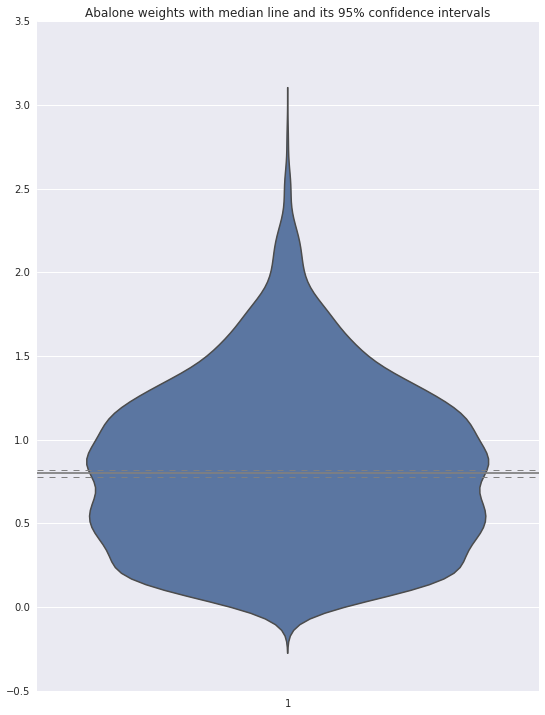

In [54]:
plt.figure(figsize=(9, 12))
sns.violinplot(data['whole weight'], inner='sticks', kernel='tri')

plt.title('Abalone weights with median line and its 95% confidence intervals')
plt.axhline(np.median(weights), color='gray')
plt.axhline(lower, linestyle='--', linewidth=1, color='gray')
plt.axhline(upper, linestyle='--', linewidth=1, color='gray');

### Exercises:

#### Exercise (a): Use ``IPython.parallel`` to parallelize the ``bootstrap_confidence_interval()`` function to run across several nodes

In [ ]:
from IPython.parallel import Client
client = Client('default')
client.ids

In [ ]:
view = client[:]

In [ ]:
@view.remote(block=True)
def bootstrap_statistics(data, num_samples, statistic_fn):
    """
    Calculates the given statistic on bootstrap samples from the data.
    """
    sampler = bootstrap_sampler(data)
    return [statistic_fn(next(sampler)) for i in range(num_samples)]

In [ ]:
import IPython
IPython.__version__

In [ ]:
def bootstrap_confidence_interval(statistics, alpha):
    """
    Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic.
    """
    assert 0 < alpha < 1
    stat = np.sort(statistics)
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

In [ ]:
bootstrap_statistics(weights, 10000, np.median)

To pickle more complex objects, use the ``dill`` package:

    $ pip install dill-0.2b1

In [ ]:
!which pip

In [ ]:
!pip install https://pypi.python.org/packages/source/d/dill/dill-0.2b1.tgz

In [ ]:
import dill

In [ ]:
sampler = bootstrap_sampler(data)